# Trabajo Práctico N5. Restauracion de Imagenes

In [63]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [64]:
#Funciones auxiliares

def myplotimg (img,vmin=0,vmax=255,title=None):
  plt.imshow(img,cmap='gray', vmin=vmin, vmax=vmax)
  if title != None:
    plt.title(title)
  plt.axis("off")
  plt.show()
  return

def show_side_by_side(imgs, subtitles = None, title = None, vmin=0, vmax=255, **kwargs):
    fig, axes = plt.subplots(1, len(imgs), **kwargs)
    if len(imgs) == 1:
        axes = [axes]
    if title is not None:
        fig.suptitle(title, y=0.8)
    if subtitles is None:
        subtitles = [None for _ in imgs]
    for ax, img, subtitle in zip(axes, imgs, subtitles):
        if subtitle is not None:
            ax.set_title(subtitle)
        ax.imshow(img, cmap='gray', vmin=vmin, vmax=vmax)
        ax.axis('off')
        
    plt.tight_layout()
    plt.show()

In [65]:
def add_noise(img):
    copy = img.copy().astype(np.float64)
    cv2.randn(copy, 0, 50)
    return np.clip(img + copy, 0, 255).astype(np.uint8)

## 1)

In [66]:
def get_gaussian_kernel(size, sigma):
    img=np.zeros((size, size))
    img[size // 2, size // 2]=1
    return cv2.GaussianBlur(img, (size, size), sigma)

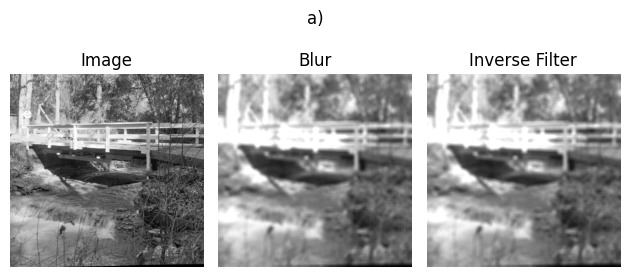

In [67]:
bridge = cv2.imread("stream_and_bridge.tiff", cv2.IMREAD_GRAYSCALE)

kernel = get_gaussian_kernel(11, 5)

blurred = cv2.filter2D(bridge,-1,kernel)

noise = add_noise(bridge)
# print(kernel)
# inv_kernel = 1/kernel
# print(inv_kernel)
# inverse_filter = cv2.filter2D(blurred, -1, inv_kernel)
# TODO: Inverse Filter
inverse_filter = blurred

show_side_by_side([bridge, blurred, inverse_filter], ["Image", "Blur", "Inverse Filter"], "a)")

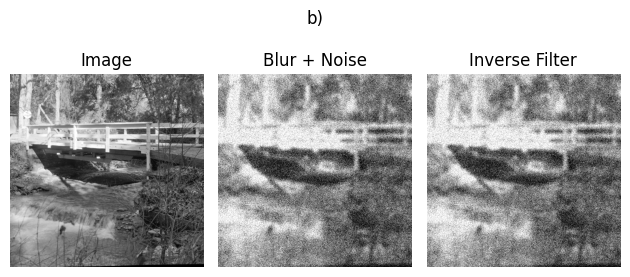

In [68]:
kernel = get_gaussian_kernel(11, 5)

blurred = add_noise(cv2.filter2D(bridge,-1,kernel))

# print(kernel)
# inv_kernel = 1/kernel
# print(inv_kernel)
# inverse_filter = cv2.filter2D(blurred, -1, inv_kernel)
# TODO: Inverse Filter
inverse_filter = blurred

show_side_by_side([bridge, blurred, inverse_filter], ["Image", "Blur + Noise", "Inverse Filter"], "b)")